# Solving Regression Challenge

### The Scenario

The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. So far, in this module, you built and implemented some models using this dataset.

In this challenge, you are required to improve your model with respect to its prediction performance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')


postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'


engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

Then let's **examine the dataset** using the `info()` and check for missing values

In [2]:
houseprices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [3]:
#look for display
houseprices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


Show me columns with **missing values**

In [4]:
houseprices_df.columns[houseprices_df.isna().any()].tolist()

['lotfrontage',
 'alley',
 'masvnrtype',
 'masvnrarea',
 'bsmtqual',
 'bsmtcond',
 'bsmtexposure',
 'bsmtfintype1',
 'bsmtfintype2',
 'electrical',
 'fireplacequ',
 'garagetype',
 'garageyrblt',
 'garagefinish',
 'garagequal',
 'garagecond',
 'poolqc',
 'fence',
 'miscfeature']

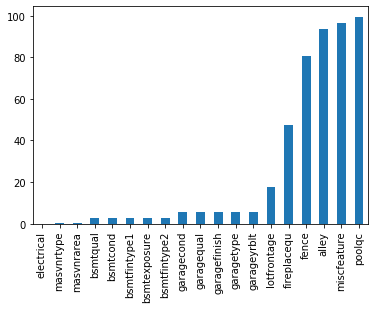

In [5]:
missing = houseprices_df.isnull().sum()*100/houseprices_df.isnull().count()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

This graph shows 19 columns has missing values where five of which has more than 20% missing data. And they are *fireplacequ, fence, alley, miscfeature and poolqc*.

In [6]:
for column_name in houseprices_df.columns:
    print("Unique values in column {} are: {}".format(column_name, houseprices_df[column_name].unique()))

Unique values in column id are: [   1    2    3 ... 1458 1459 1460]
Unique values in column mssubclass are: [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
Unique values in column mszoning are: ['RL' 'RM' 'C (all)' 'FV' 'RH']
Unique values in column lotfrontage are: [ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]
Unique values in column lotarea are: [ 8450  9600 11250 ... 17217 13175  9717]
Unique values in column street are: ['Pave' 'Grvl']
Unique values in column 

**Categorical Values**
 'alley', 'masvnrtype', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1',  'bsmtfintype2', 'electrical', 'fireplacequ', 'garagetype',  'garagefinish', 'garagequal', 'garagecond', 'poolqc',  'fence',  'miscfeature'
 
**Continuous Values**
 'lotfrontage', 'masvnrarea', 'garageyrblt'
 
 What do we do with these missing information?
 Since most of them are categorical values we can continue with our model.

In [7]:
# Drop other columns 
houseprices_df.drop(['fireplacequ', 'fence', 'alley', 'miscfeature', 'poolqc'], 1, inplace=True)

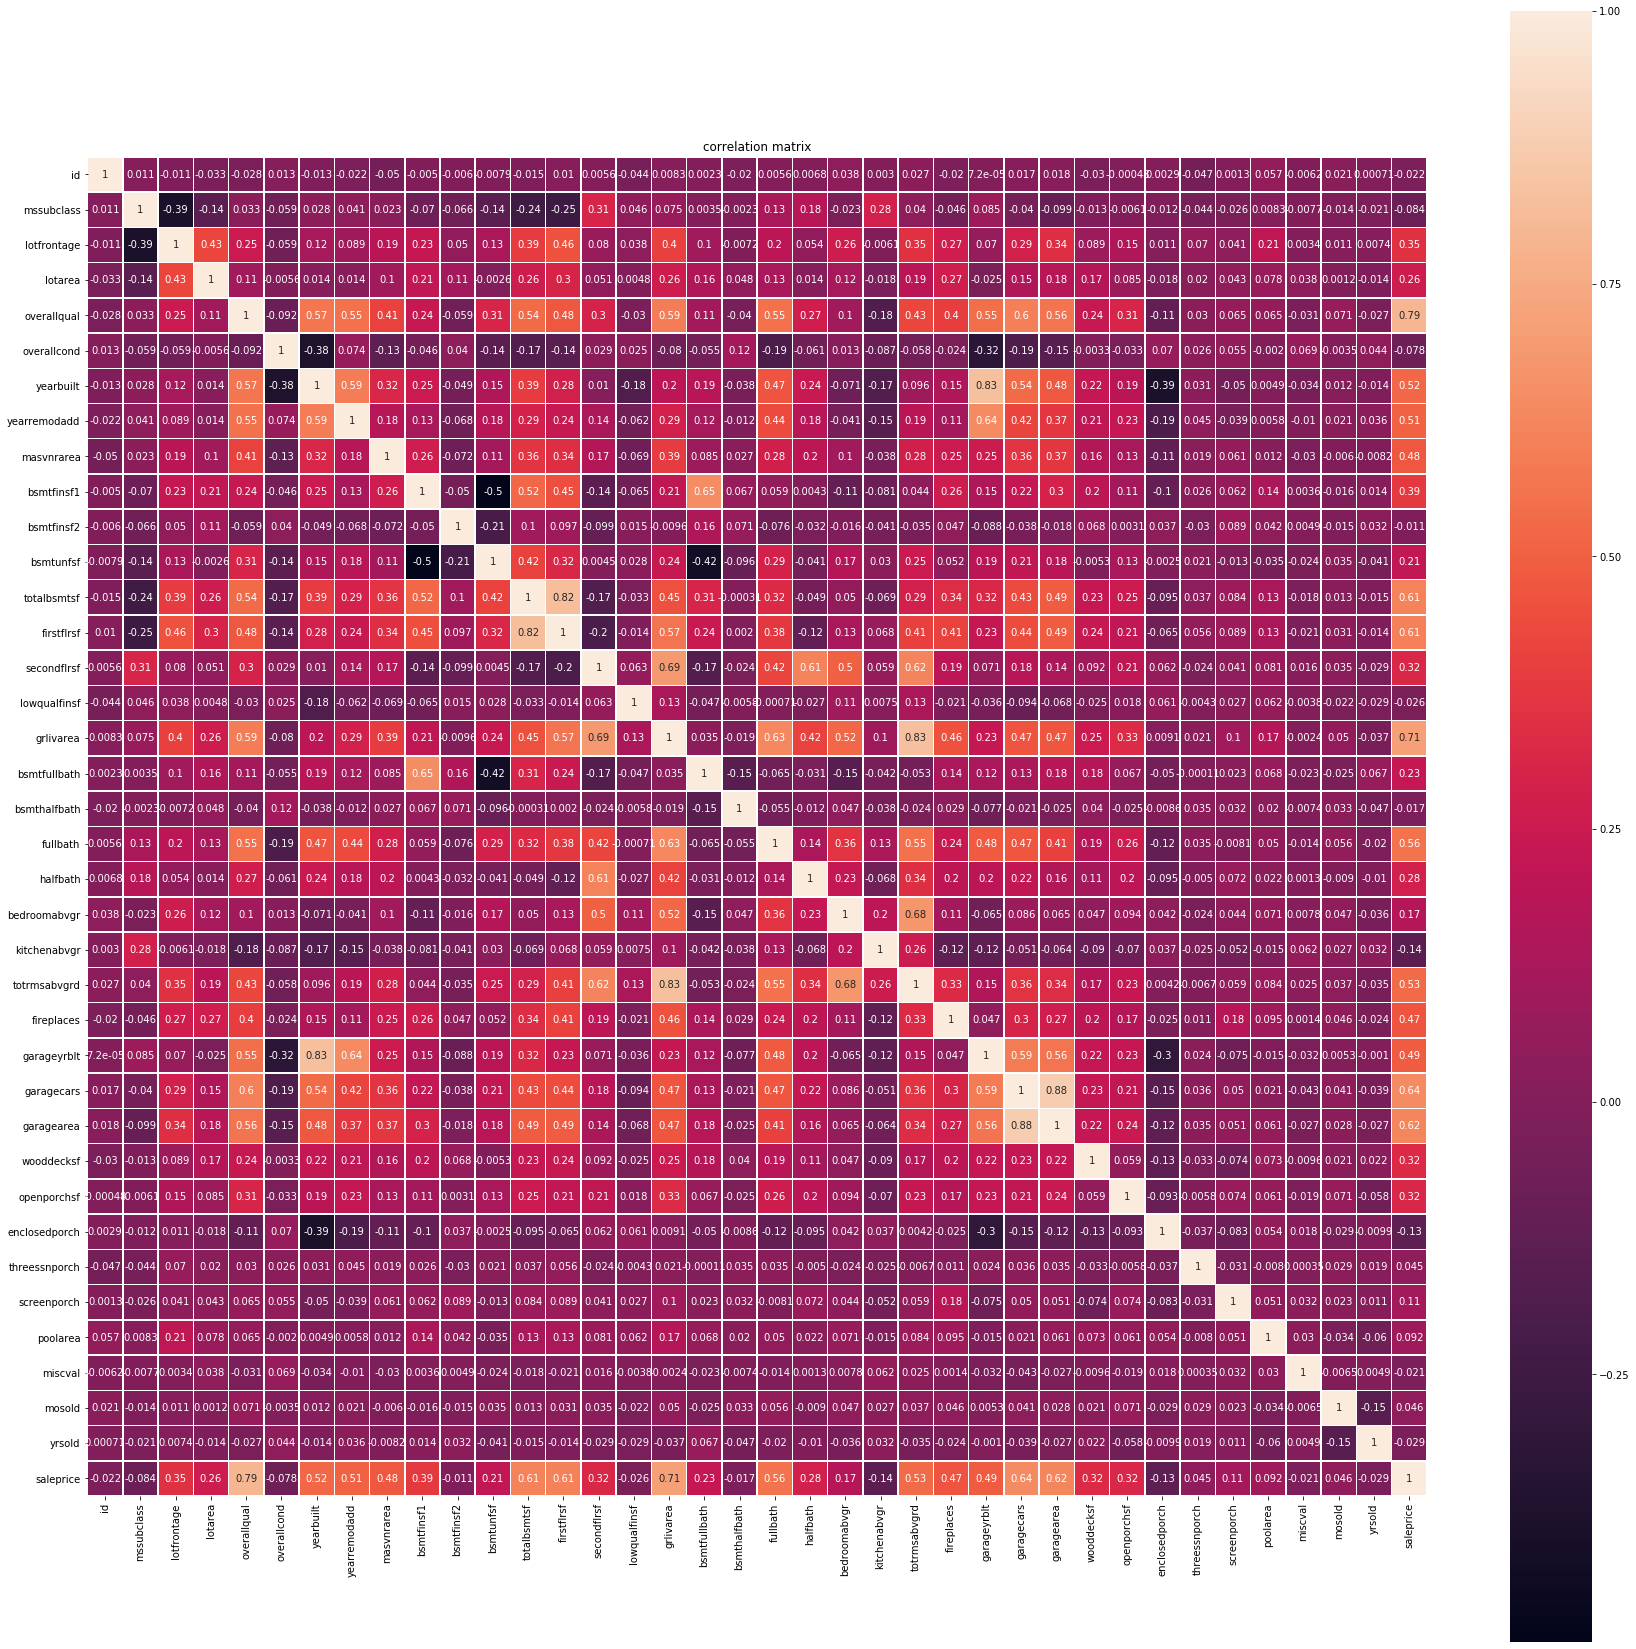

In [8]:
import seaborn as sns

houseprices_cmat = houseprices_df.corr()

plt.figure(figsize=(30,30))

# draw the heatmap using seaborn.
sns.heatmap(houseprices_cmat, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix")
plt.show()

In [9]:
# Drop more columns that are correlated to each other
houseprices_df.drop(['garagecars', 'garageyrblt', 'grlivarea', 'totalbsmtsf', 
                     'enclosedporch','bsmtfullbath','bsmthalfbath'], 1, inplace=True)

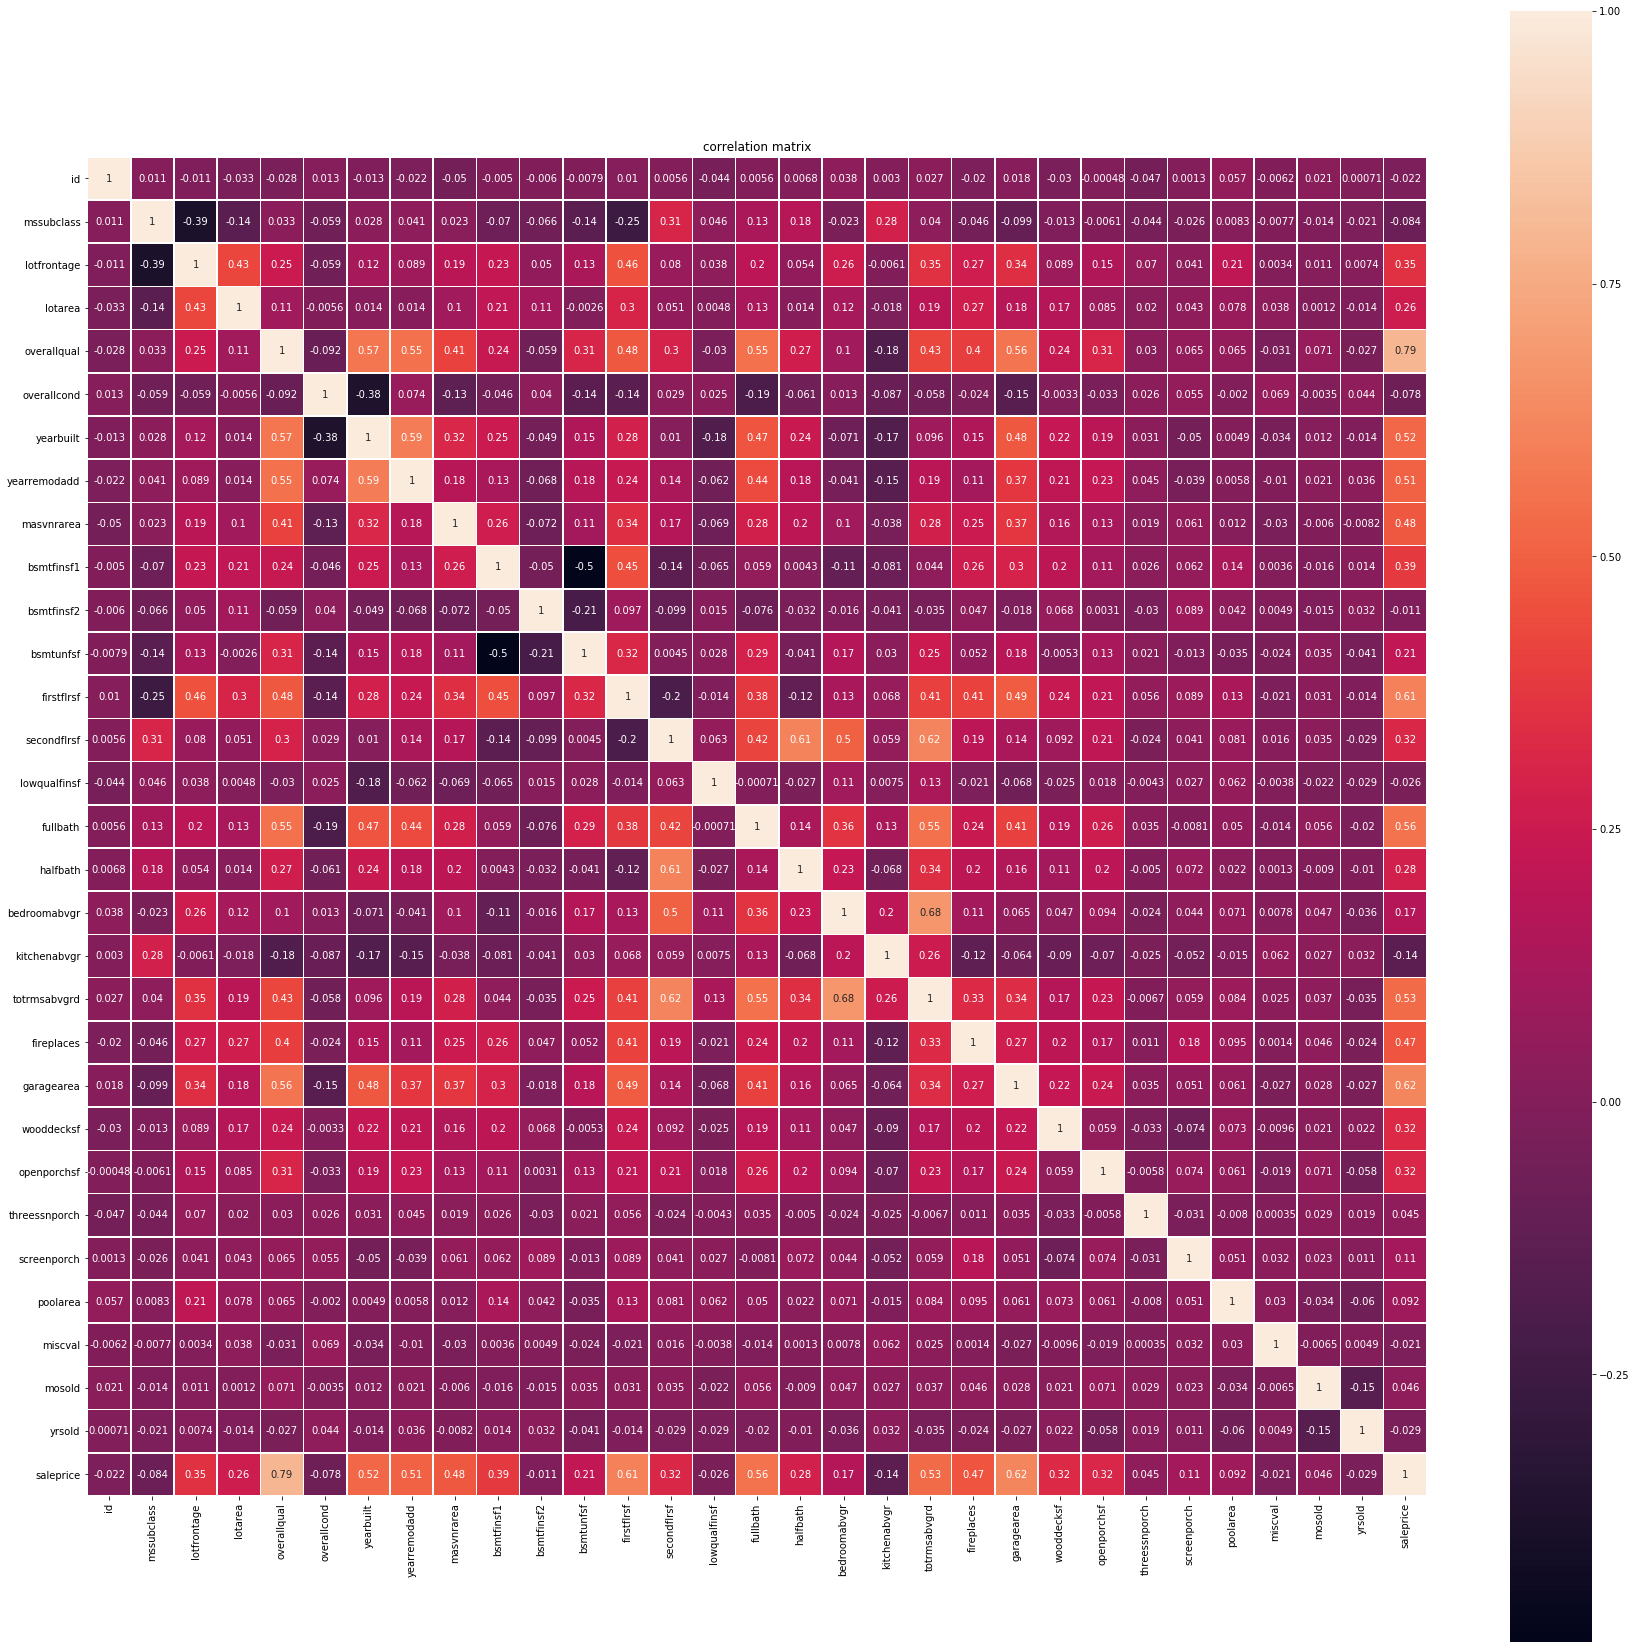

In [10]:
houseprices_cmat = houseprices_df.corr()

plt.figure(figsize=(30,30))

# draw the heatmap using seaborn.
sns.heatmap(houseprices_cmat, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix")
plt.show()

In [11]:
#one last clean up

# Drop more columns that are negative correlated to our target
houseprices_df.drop(['overallcond', 'bsmtfinsf1','bsmtfinsf2','lowqualfinsf','miscval',
                    'id','lotfrontage','kitchenabvgr','miscval','mssubclass'], 1, inplace=True)

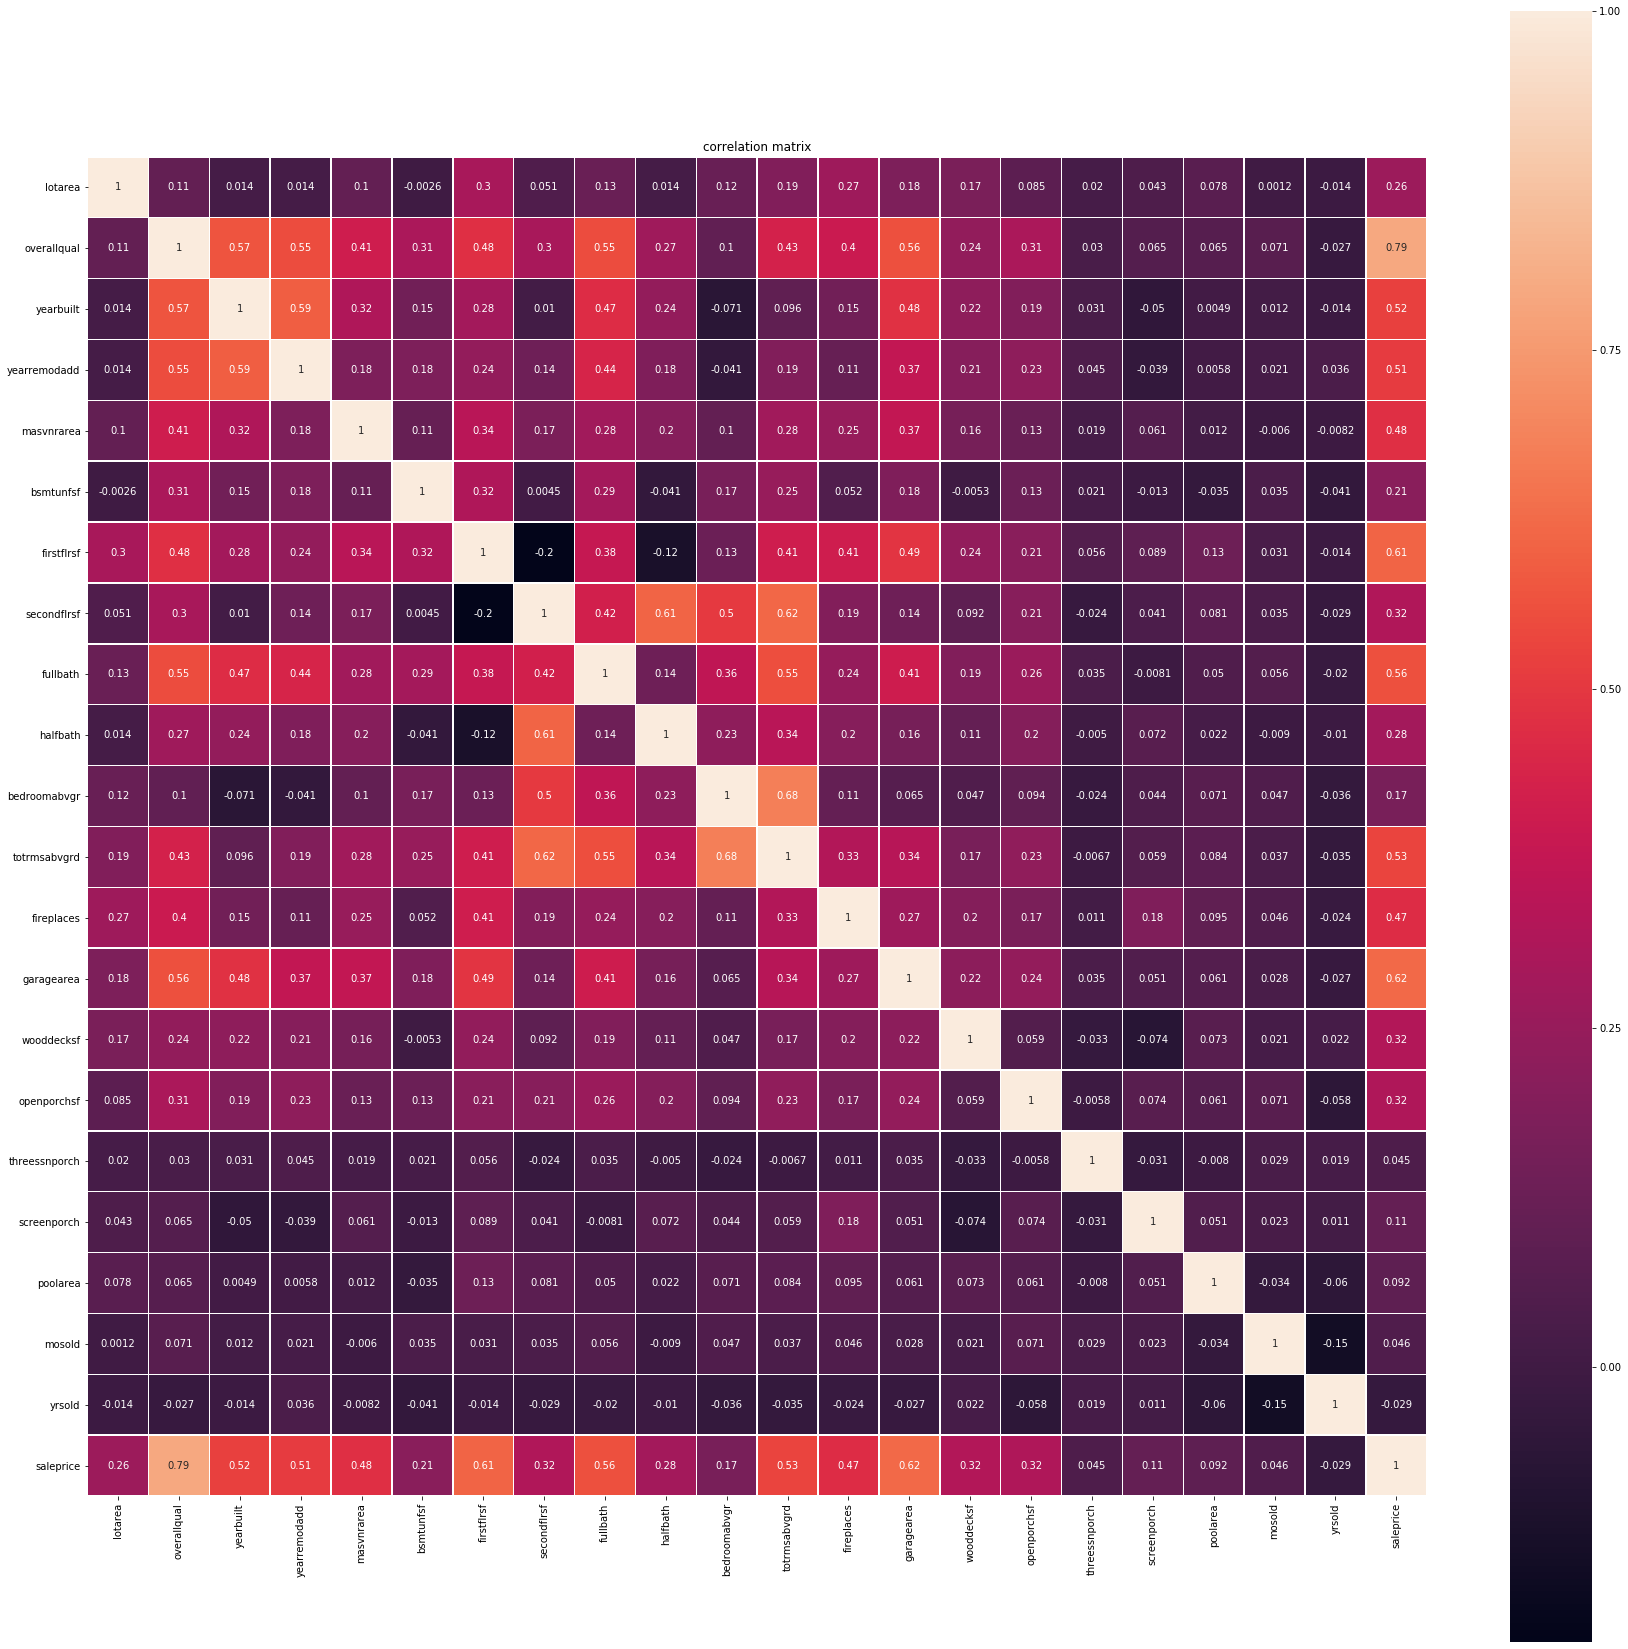

In [12]:
houseprices_cmat = houseprices_df.corr()

plt.figure(figsize=(30,30))

# draw the heatmap using seaborn.
sns.heatmap(houseprices_cmat, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix")
plt.show()

#### Do we have any Outliers?

Let's review all the column left and look for outliers.

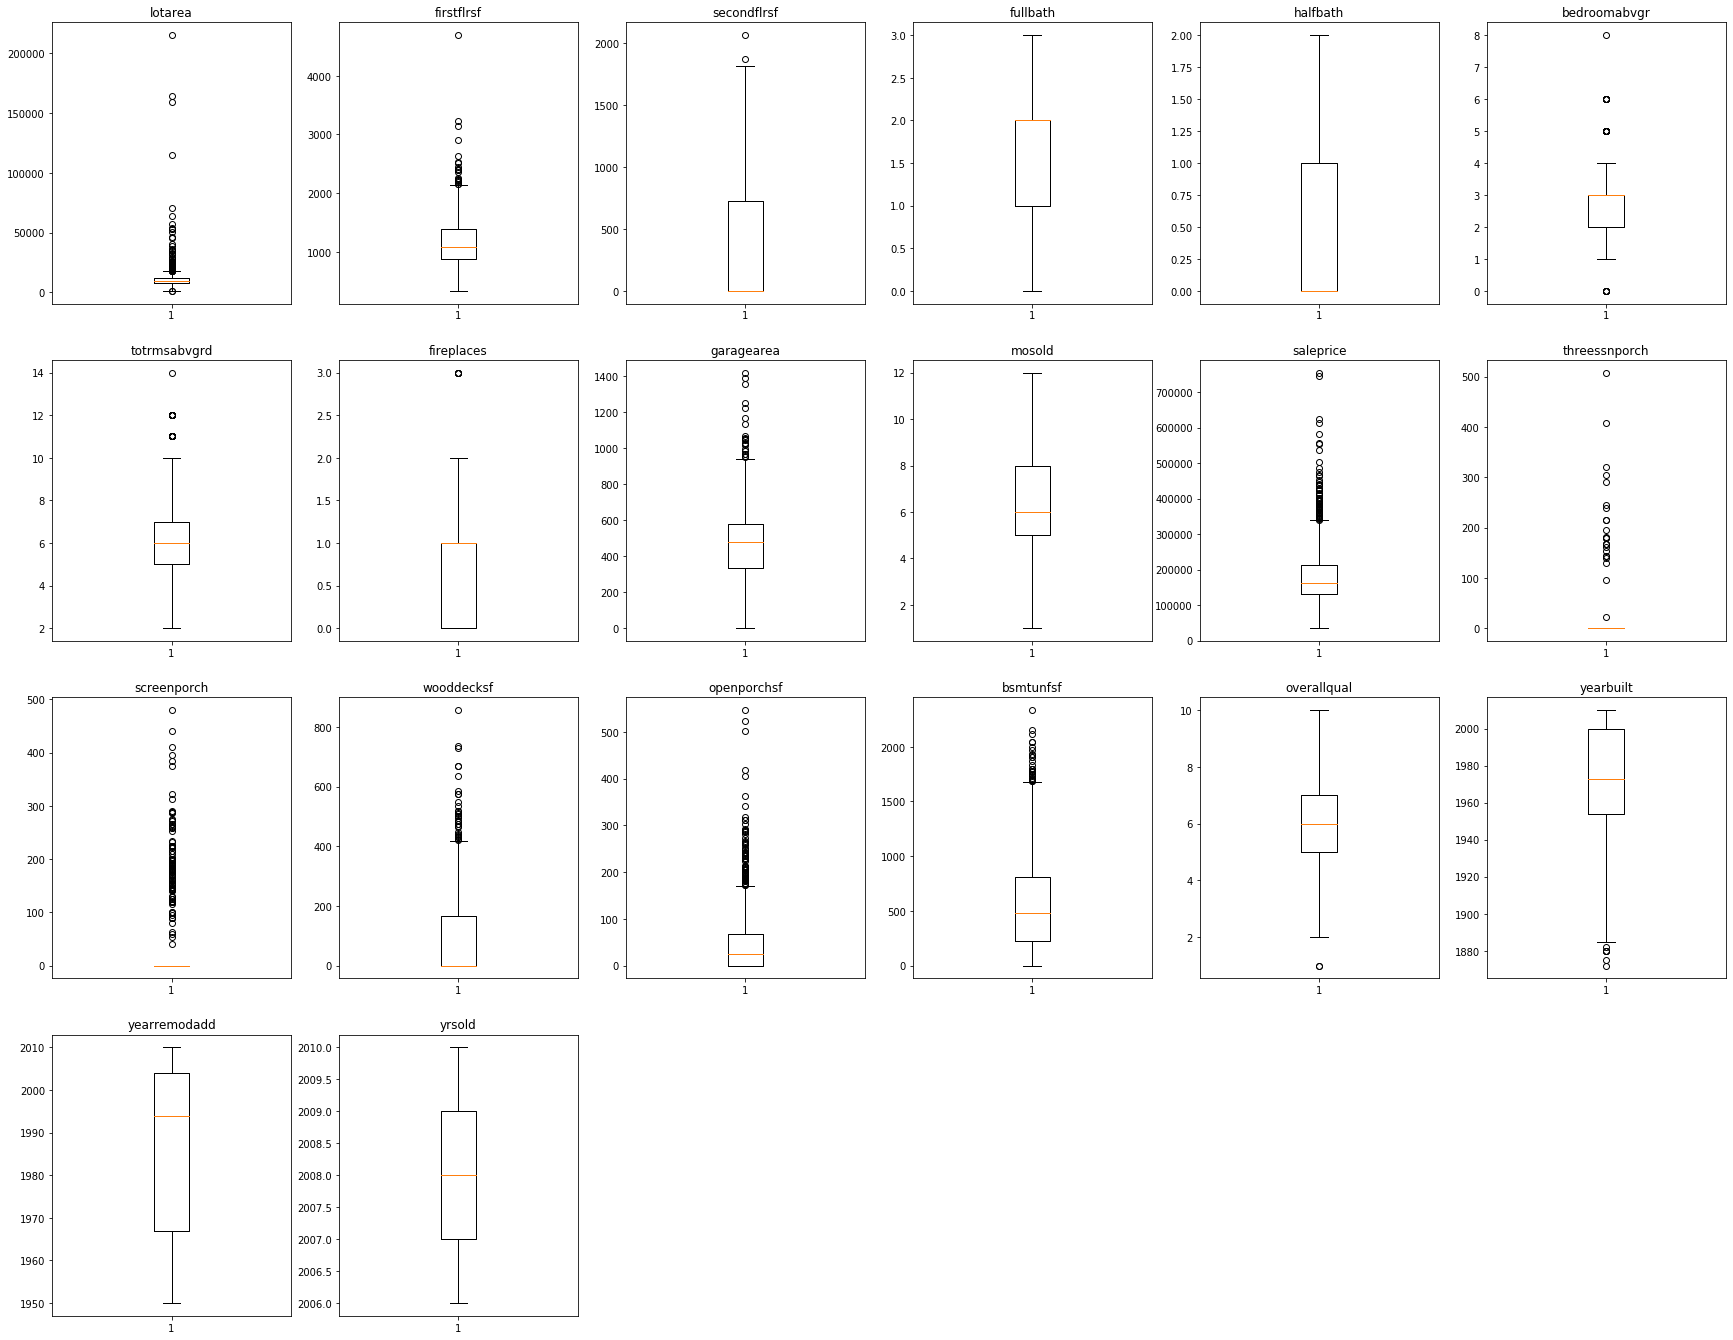

In [13]:
plt.figure(figsize = (30,30))

plot_columns = ["lotarea", "firstflrsf", "secondflrsf", "fullbath", "halfbath",
                "bedroomabvgr", "totrmsabvgrd", "fireplaces", "garagearea",
                "mosold", "saleprice", "threessnporch", "screenporch", "wooddecksf", 
                "openporchsf", "bsmtunfsf", "overallqual", "yearbuilt", "yearremodadd", "yrsold"]
i = 1

for plot_column in plot_columns:
    plt.subplot(5,6,i)
    plt.boxplot(houseprices_df[plot_column])
    plt.title(plot_column)
    i = i +1


plt.show()

In [14]:
from scipy.stats.mstats import winsorize

#the columns that we want to winsorize
#"firstflrsf", "secondflrsf", "bedroomabvgr", "totrmsabvgrd", "garagearea", "fireplaces", "threessnporch", 
#"screenporch", "wooddecksf", "openporchsf", "bsmtunfsf","yearbuilt", "lotarea"

houseprices_df["lotarea"] = winsorized_views = winsorize(houseprices_df["lotarea"], (0, 0.10))
houseprices_df["firstflrsf"] = winsorized_views = winsorize(houseprices_df["firstflrsf"], (0, 0.10))

houseprices_df["secondflrsf"] = winsorized_views = winsorize(houseprices_df["secondflrsf"], (0, 0.10))
houseprices_df["bedroomabvgr"] = winsorized_views = winsorize(houseprices_df["bedroomabvgr"], (0, 0.10))

houseprices_df["totrmsabvgrd"] = winsorized_views = winsorize(houseprices_df["totrmsabvgrd"], (0, 0.10))
houseprices_df["garagearea"] = winsorized_views = winsorize(houseprices_df["garagearea"], (0, 0.10))

houseprices_df["fireplaces"] = winsorized_views = winsorize(houseprices_df["fireplaces"], (0, 0.10))
houseprices_df["threessnporch"] = winsorized_views = winsorize(houseprices_df["threessnporch"], (0, 0.10))

houseprices_df["screenporch"] = winsorized_views = winsorize(houseprices_df["screenporch"], (0, 0.10))
houseprices_df["wooddecksf"] = winsorized_views = winsorize(houseprices_df["wooddecksf"], (0, 0.10))

houseprices_df["openporchsf"] = winsorized_views = winsorize(houseprices_df["openporchsf"], (0, 0.10))
houseprices_df["bsmtunfsf"] = winsorized_views = winsorize(houseprices_df["bsmtunfsf"], (0, 0.10))

houseprices_df["yearbuilt"] = winsorized_views = winsorize(houseprices_df["yearbuilt"], (0, 0.10))
houseprices_df["saleprice"] = winsorized_views = winsorize(houseprices_df["saleprice"], (0, 0.10))

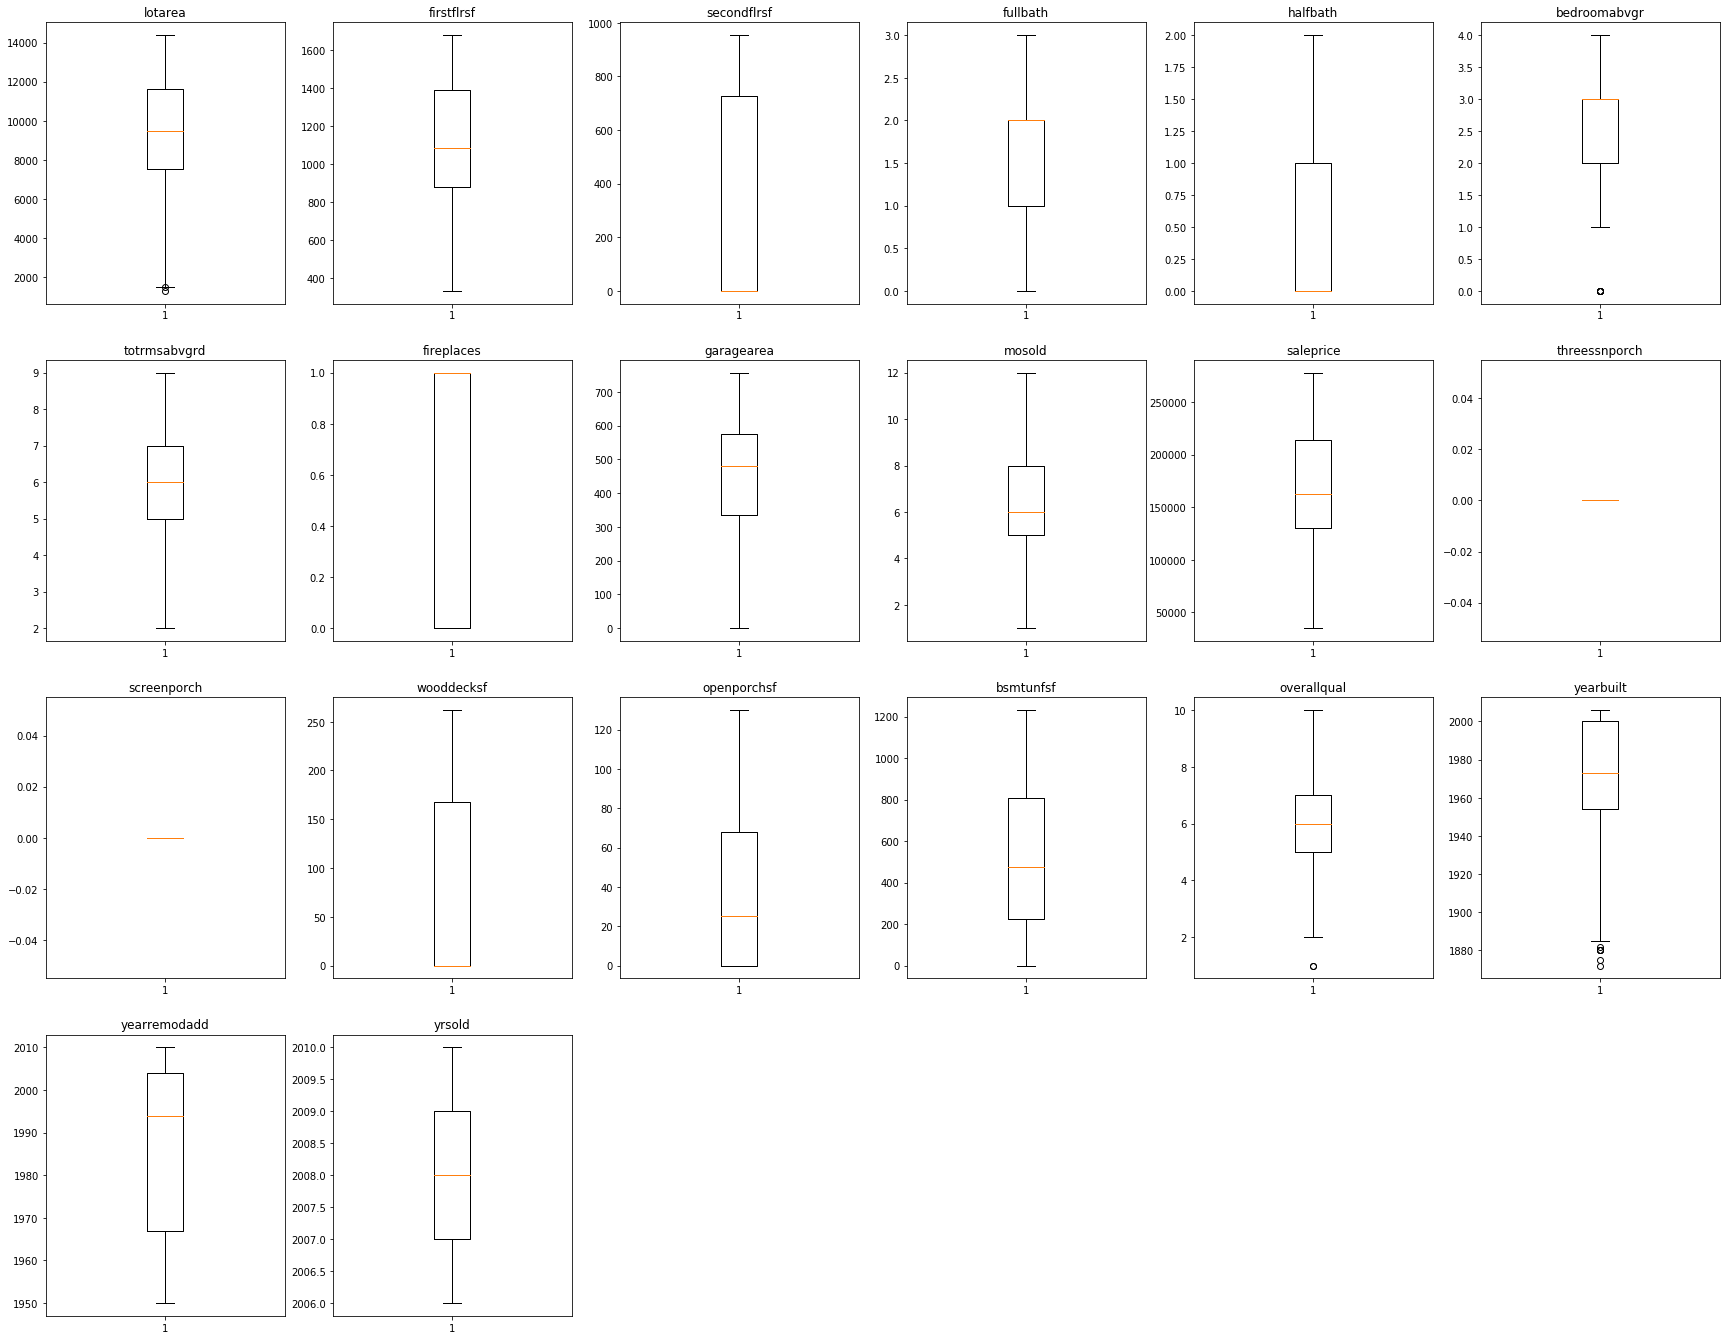

In [15]:
plt.figure(figsize = (30,30))

plot_columns = ["lotarea", "firstflrsf", "secondflrsf", "fullbath", "halfbath",
                "bedroomabvgr", "totrmsabvgrd", "fireplaces", "garagearea",
                "mosold", "saleprice", "threessnporch", "screenporch", "wooddecksf", 
                "openporchsf", "bsmtunfsf", "overallqual", "yearbuilt", "yearremodadd", "yrsold"]
i = 1

for plot_column in plot_columns:
    plt.subplot(5,6,i)
    plt.boxplot(houseprices_df[plot_column])
    plt.title(plot_column)
    i = i +1


plt.show()

In [16]:
#clean up from our box plot

houseprices_df.drop(['screenporch','threessnporch'], 1, inplace=True)

---
#### TARGET variable and FEATURE sets

In [17]:
# Y is the target variable
Y = houseprices_df['saleprice']
# X is the feature set
X = houseprices_df[['overallqual', 'garagearea']]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     1843.
Date:                Mon, 21 Oct 2019   Prob (F-statistic):               0.00
Time:                        21:46:50   Log-Likelihood:                -17171.
No. Observations:                1460   AIC:                         3.435e+04
Df Residuals:                    1457   BIC:                         3.436e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.464e+04   3676.385     -9.423      0.000   -4.19e+04   -2.74e+04
overallqual  2.729e+04    712.087     38.323      0.000    2.59e+04    2.87e+04
garagearea     89.4099      5.189     17.232      0.000      79.232      99.588
==============================================================================
Omnibus:                       39.101   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.256
Skew:                           0.177   Prob(JB):                     1.24e-16
Kurtosis:                       4.038   Cond. No.                     2.28e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Splitting the Data
Split the data into train and test sets where 20% of the data resides in the test set.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


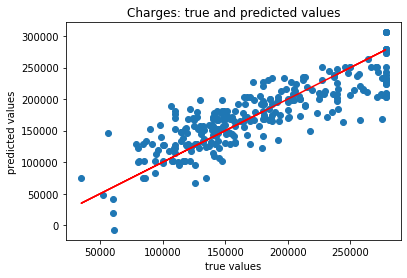

Mean absolute error of the prediction is: 24892.01175443342
Mean squared error of the prediction is: 1033502859.4113895
Root mean squared error of the prediction is: 32148.139283812205
Mean absolute percentage error of the prediction is: 16.485546538652645


In [19]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format
      (mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}"
      .format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

### Linear Regression Models

Build several linear regression models including *Lasso, Ridge, or ElasticNet* and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!

In [20]:
from sklearn.linear_model import LinearRegression

Y = houseprices_df['saleprice']

numerical_cols = [col_name for col_name in houseprices_df.dtypes
                  [houseprices_df.dtypes.values == 'int64'].index 
                    if col_name not in ["id", "saleprice"] ]

X = houseprices_df[numerical_cols]

X = pd.concat([X**i for i in range(1,21)], axis=1)

# X is the feature set

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format
      (mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format
      (np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


The number of observations in training set is 1168
The number of observations in test set is 292
R-squared of the model in the training set is: 0.8434892307530458
-----Test set statistics-----
R-squared of the model in the test set is: -1.4957635252189812e+22
Mean absolute error of the prediction is: 803103138126898.2
Mean squared error of the prediction is: 5.277992443011581e+31
Root mean squared error of the prediction is: 7264979313811968.0
Mean absolute percentage error of the prediction is: 339024725327.1993


In [21]:
from sklearn.linear_model import LinearRegression

# This is the model with linear feature
lrm_underfit = LinearRegression().fit(X, Y)
preds_underfit = lrm_underfit.predict(X)

# This is the model with quadratic feature
X_correct = pd.concat([X, X**2], axis=1)
lrm_correct = LinearRegression().fit(X_correct, Y)
preds_correct = lrm_correct.predict(X_correct)

# This is the model with up to 10th order polynomial of the feature
X_overfit = pd.concat([X**i for i in range(1,11)], axis=1)
lrm_overfit = LinearRegression().fit(X_overfit, Y)
preds_overfit = lrm_overfit.predict(X_overfit)

**Ridge**

In [22]:
from sklearn.linear_model import Ridge

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=10**37) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format
      (ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format
      (mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format
      (np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.6148662629637905
-----Test set statistics-----
R-squared of the model on the test set is: 0.4331398007615894
Mean absolute error of the prediction is: 34851.92948979761
Mean squared error of the prediction is: 2000238538.6328735
Root mean squared error of the prediction is: 44724.02641347124
Mean absolute percentage error of the prediction is: 22.830506991657604


**Lasso**

In [23]:
from sklearn.linear_model import Lasso

lassoregr = Lasso(alpha=10**20.5) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format
      (lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format
      (mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format
      (np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.6273829709543739
-----Test set statistics-----
R-squared of the model on the test set is: 0.4530316043549085
Mean absolute error of the prediction is: 34190.216199642084
Mean squared error of the prediction is: 1930047771.6611767
Root mean squared error of the prediction is: 43932.308972567975
Mean absolute percentage error of the prediction is: 22.369232272420067


**ElasticNet**

In [24]:
from sklearn.linear_model import ElasticNet

elasticregr = ElasticNet(alpha=10**21, l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format
      (elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format
      (elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format
      (mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format
      (np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.5831890286250054
-----Test set statistics-----
R-squared of the model on the test set is: 0.4276452879663668
Mean absolute error of the prediction is: 35125.9828655967
Mean squared error of the prediction is: 2019626628.0749996
Root mean squared error of the prediction is: 44940.256208381805
Mean absolute percentage error of the prediction is: 23.047133233388656


### Initial Model
Between Ridge, Lasso, and ElasticNet, the last model has the closest. It has the closed value between traning and test set and it also has the lease about of error of predictions. ElasticNet is the most accurate between the three.

### k-fold cross-validation 

In [25]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format
      (ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format
      (mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format
      (np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e+23
R-squared of the model in training set is: 0.8794811711165381
-----Test set statistics-----
R-squared of the model in test set is: 0.7806425940030185
Mean absolute error of the prediction is: 18868.229419047977
Mean squared error of the prediction is: 774030594.8436557
Root mean squared error of the prediction is: 27821.40533552638
Mean absolute percentage error of the prediction is: 12.507373954038936


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [26]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format
      (lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format
      (mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format
      (rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format
      (np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 10000000000000.0
R-squared of the model in training set is: 0.8610630926995898
-----Test set statistics-----
R-squared of the model in test set is: -53.11548814794912
Mean absolute error of the prediction is: 69037.71692799745
Mean squared error of the prediction is: 190953404518.23294
Root mean squared error of the prediction is: 436982.15583503287
Mean absolute percentage error of the prediction is: 33.14877011555444


In [27]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format
      (elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format
      (elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format
      (mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format
      (np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 100000000000000.0
R-squared of the model in training set is: 0.8581796784486742
-----Test set statistics-----
R-squared of the model in test set is: 0.6168643305747523
Mean absolute error of the prediction is: 20831.753395803542
Mean squared error of the prediction is: 1351943093.7979252
Root mean squared error of the prediction is: 36768.77879122348
Mean absolute percentage error of the prediction is: 13.38567215252637


### Evaluation Time

Evaluate your best model on the test set.

When we do the k-fold cross validation in our data all of the model has noticebly improved. **RidgeCV** has the closes value between test and traning. This model is also has the least amount of error.

---

So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model

### Acknowledgements
The interest rate data was published by the Federal Reserve Bank of St. Louis' economic data portal. The gross domestic product data was provided by the US Bureau of Economic Analysis; the unemployment and consumer price index data was provided by the US Bureau of Labor Statistics. 

From the dataset found here https://www.kaggle.com/federalreserve/interest-rates we're only using data from 2006 - 2010. This data is manipulated prior to loading the data to this notebook.

### Other factors: Unemployment Rate
Unemployment rate is another factor that would affect the housing market. If 

In [36]:
unemp_df = pd.read_csv('downloads/ave_unemp_rate.csv')

In [37]:
hp_unemp = pd.merge(houseprices_df, unemp_df, on='yrsold')

Let's check if it merged correctly.

In [38]:
hp_unemp.head()

,mszoning,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,...,wooddecksf,openporchsf,poolarea,mosold,yrsold,saletype,salecondition,saleprice,ave_inflation,ave_unemployment
0,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,0,61,0,2,2008,WD,Normal,208500,2.31,5.8
1,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,0,42,0,9,2008,WD,Normal,223500,2.31,5.8
2,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,192,84,0,12,2008,WD,Normal,250000,2.31,5.8
3,RM,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,...,90,0,0,4,2008,WD,Abnorml,129900,2.31,5.8
4,RL,7420,Pave,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,...,0,4,0,1,2008,WD,Normal,118000,2.31,5.8


In [39]:
hp_unemp.tail()

,mszoning,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,...,wooddecksf,openporchsf,poolarea,mosold,yrsold,saletype,salecondition,saleprice,ave_inflation,ave_unemployment
1455,RM,7407,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,...,0,130,0,4,2010,WD,Normal,149700,0.95,9.6
1456,RL,14375,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,...,261,39,0,4,2010,WD,Normal,157900,0.95,9.6
1457,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,262,0,0,2,2010,WD,Normal,210000,0.95,9.6
1458,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,0,60,0,5,2010,WD,Normal,266500,0.95,9.6
1459,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,262,0,0,4,2010,WD,Normal,142125,0.95,9.6


New let's use the OLS Regression and let's use the following data as the feature set: *Lot Area, Average Unemployment Rate, Overall quality and the year sold.*

In [41]:
# Y is the target variable
Yemp = hp_unemp['saleprice']
# X is the feature set
Xemp = hp_unemp[['lotarea','ave_unemployment','overallqual','yrsold', 'ave_inflation']]

Xemp = sm.add_constant(Xemp)
results = sm.OLS(Yemp, Xemp).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     779.1
Date:                Mon, 21 Oct 2019   Prob (F-statistic):               0.00
Time:                        22:02:32   Log-Likelihood:                -17141.
No. Observations:                1460   AIC:                         3.429e+04
Df Residuals:                    1454   BIC:                         3.433e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             6.631e+05   3.46e+06      0.191      0.848   -6.13e+06    7.46e+06
lotarea              4.9690      0.259     19.193      0.000       4.461       5.477
ave_unemployment  -692.0686   1119.780     -0.618      0.537   -2888.626    1504.489
overallqual       3.156e+04    592.811     53.237      0.000    3.04e+04    3.27e+04
yrsold            -357.7734   1725.919     -0.207      0.836   -3743.330    3027.783
ave_inflation    -3201.2101   4290.834     -0.746      0.456   -1.16e+04    5215.677
==============================================================================
Omnibus:                       39.941   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.382
Skew:                          -0.157   Prob(JB):                     5.79e-18
Kurtosis:                       4.098   Cond. No.                     4.40e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.4e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Another factor would be location.
As they say in buying a house, LOCATION, LOCATION, LOCATION. Location is important in buying a house. When your house is built near a school, you will have Mello Roos that you need to factor in. Another factor is the crime rate in the area. If the house is built using the best material and using best technology that money could buy, you may get a good deal if the crime rate is high. If your house is in a cliff and your in California, earthquakes are something we need to factor in. What natural disaster may the area have? The better the weather the higher the cost. The distance to a natural attraction like a beach or a lake can make a house more desirable.